In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import os

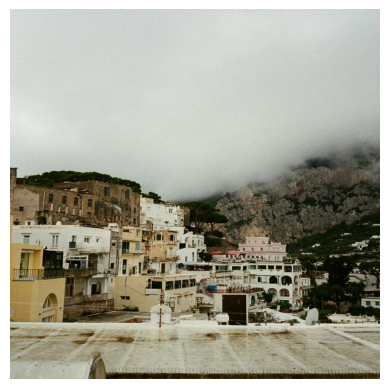

In [ ]:
builing = Image.open('buildings.jpg')
builing = np.array(builing)
plt.imshow(builing)
plt.axis('off')
plt.show()

In [9]:
builing.shape

(1024, 1024, 3)

In [57]:
M = 256
PI = np.pi

# Each needs its own copy
x1 = np.zeros((M, M))
x2 = np.zeros((M, M))
x3 = np.zeros((M, M))

# Horizontal sinusoid
for m in range(M):
    x1[m, :] = np.sin(PI * m * 24 / M)

# Vertical sinusoid
for n in range(M):
    x2[:, n] = np.sin(PI * n * 16 / M)

# Diagonal sinusoid
for m in range(M):
    for n in range(M):
        x3[m, n] = np.sin(2 * PI * (6 * m + 10 * n) / M)

# Combine
x = np.mean([x1, x2, x3], axis=0)


In [58]:
DFT = np.fft.fft2(x)
DFT_abs = np.abs(DFT)

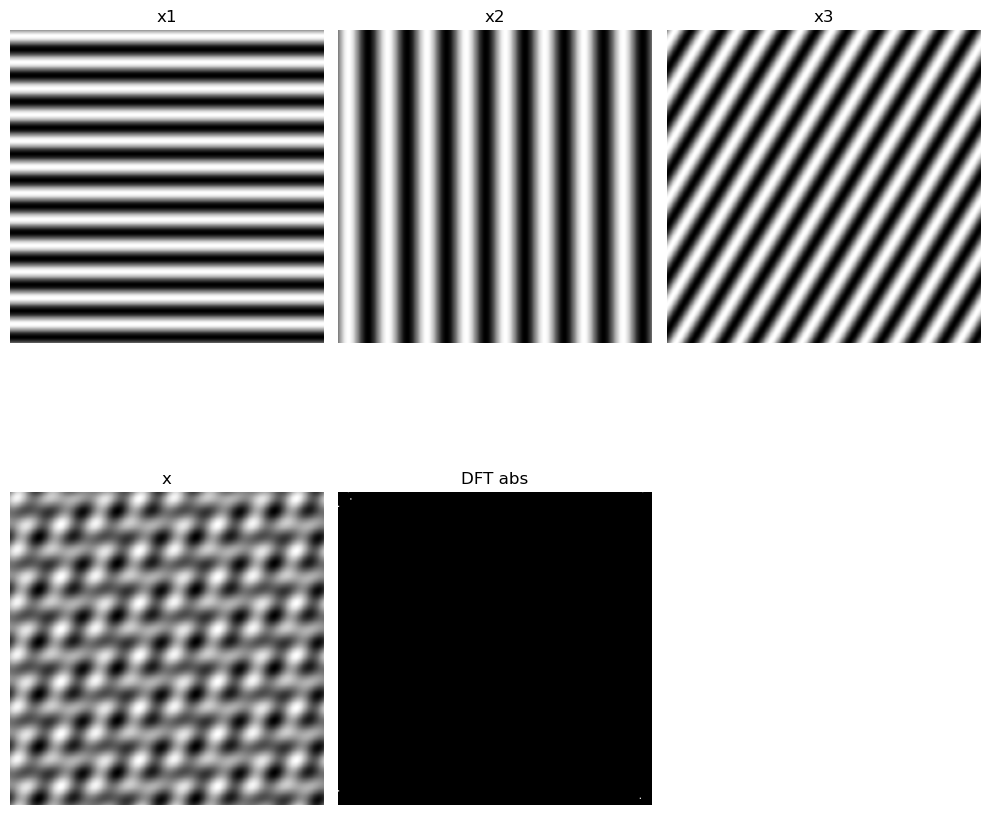

In [59]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(x1,cmap='gray')
plt.title('x1')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(x2,cmap='gray')
plt.title('x2')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(x3,cmap='gray')
plt.title('x3')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(x,cmap='gray')
plt.title('x')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(DFT_abs,cmap='gray')
plt.title('DFT abs')
plt.axis('off')
plt.tight_layout()
plt.show()